#Introduction
CISC 452 Project - Hurricane Trajectory and Intensity Prediction (GRU)

*   Description: The following code trains a network to predict the next latitude, longtitude, wind pressure, wind speed and storm direction in 6 hours given the past values from 24 hours (6 hour time intervals). The predictions from the model are then fed back into the model as input, to predict the latitude, longtitude, wind pressure, wind speed and storm direction at 24 hours.


*   Citation: Functions multivariate_data & multi_step_plot are from https://www.tensorflow.org/tutorials/structured_data/time_series?fbclid=IwAR2wmmrcGwp_7n_pBtvJv9yfNYQMiRqHviVCKsSIEgVW8TMHxb9kYHktSsA



By: Cindy Wu | 10192940 | 15cmw2 | Group 15

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import pandas as pd
import folium
import datetime as dt
import dateutil.parser
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
tf.__version__
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


# Dataset Processing


*   Load data from csv
*   Filter out bad data (ensure timestamps are 6 hour intervals apart, remove storms that don't contain enough data/missing data)
*   Normalize the data



In [2]:
# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/NA_basin.csv'
df = pd.read_csv(url, header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
min_year = 1981
dataset_1980p = df.loc[df["SEASON"] >= min_year]

In [4]:
dataset_1980p.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,...,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
4184,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-06 18:00,TS,18.4,-83.6,30,1006,hurdat_atl,main,300,300,O_____________,hurdat_atl,AL031981,18.4,-83.6,,TD,30,1006,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,8,92
4185,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 0:00,TS,18.4,-82.7,30,1006,hurdat_atl,main,335,328,O_____________,hurdat_atl,AL031981,18.4,-82.7,,TD,30,1006,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9,85
4186,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 6:00,TS,18.6,-81.7,30,1005,hurdat_atl,main,333,300,O_____________,hurdat_atl,AL031981,18.6,-81.7,,TD,30,1005,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,74
4187,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 12:00,TS,19.0,-80.6,35,1003,hurdat_atl,main,248,219,O_____________,hurdat_atl,AL031981,19.0,-80.6,,TS,35,1003,0,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,62
4188,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 18:00,TS,19.6,-79.7,40,1000,hurdat_atl,main,199,148,O_____________,hurdat_atl,AL031981,19.6,-79.7,,TS,40,1000,0,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,53


In [5]:
hurricane_SID = []
for i in range(1, len(dataset_1980p)):
  if (dataset_1980p.iloc[i][0] not in hurricane_SID):
    hurricane_SID.append(dataset_1980p.iloc[i][0])

print(hurricane_SID)
print(len(hurricane_SID))

['1981127N18276', '1981181N36295', '1981215N36292', '1981219N11334', '1981244N30287', '1981247N16300', '1981250N15306', '1981255N14311', '1981265N14328', '1981303N25313', '1981307N17279', '1981317N31286', '1982154N22273', '1982169N26274', '1982241N14338', '1982252N26269', '1982257N20291', '1982274N25295', '1983228N27270', '1983236N26284', '1983254N30296', '1983270N28287', '1984231N33295', '1984242N11309', '1984244N13319', '1984244N37293', '1984253N29283', '1984258N20264', '1984260N14339', '1984261N29295', '1984267N31302', '1984270N23287', '1984281N24291', '1984311N15291', '1984348N35300', '1985197N29296', '1985202N26275', '1985222N32280', '1985224N18279', '1985240N20286', '1985259N24289', '1985260N13336', '1985265N30286', '1985280N18291', '1985299N25270', '1985320N21296', '1986156N26284', '1986175N26273', '1986226N30276', '1986250N11308', '1986254N22309', '1986323N23297', '1987220N34283', '1987222N26266', '1987230N15340', '1987249N15329', '1987252N11342', '1987263N10309', '1987282N1527

In [0]:
def CleanStorm(interval,storm):
  toRemove = []
  lastCleanTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[0])
  # check if the last correct time minus the current time is in the correct interval
  for i in range(1,len(storm)):
    nextTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[i])
    tDelta = nextTime - lastCleanTime
    if tDelta == interval:
      lastCleanTime = nextTime
    else:
      toRemove.append(storm.iloc[i])

  # Remove the bad data
  storm = storm.set_index("ISO_TIME")
  for r in toRemove:
    storm.drop(r['ISO_TIME'], axis=0)
  return storm


In [7]:
# Clean storms
hurricane_SID_remove = []

for i in range(0, len(hurricane_SID)):
  hurricanes = []

  # Columns to filter
  filter_SID = (dataset_1980p[dataset_1980p.columns[0]].str.strip() == hurricane_SID[i])
  filtered_data = dataset_1980p[filter_SID]

  filtered_data = CleanStorm(6, filtered_data)
  if (len(filtered_data) < 8):
    hurricane_SID_remove.append(hurricane_SID[i])

for storm in hurricane_SID_remove:
  hurricane_SID.remove(storm)

print(len(hurricane_SID))

504


In [0]:
def retreiveDatasetByName(sid, ds, ds_values):
  filtered_ds_values = []
  for i in range(len(ds)):
    if (ds.iloc[i].SID == sid):
      filtered_ds_values.append(ds_values[i])
  return np.array(filtered_ds_values)

In [0]:
TRAIN_SPLIT = int(len(hurricane_SID) * 0.8) #80% of data for training

In [0]:
tf.random.set_seed(13)

In [11]:
features_considered = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_DIR']

features = df[features_considered]
features.index = df['ISO_TIME']

features.head()

,LAT,LON,WMO_WIND,WMO_PRES,STORM_DIR
ISO_TIME,,,,,
1852-08-26 06:00:00,30.1000,-88.6000,100,961,2
1853-09-03 12:00:00,19.3333,-56.1667,130,924,297
1854-09-07 12:00:00,28.2000,-78.5667,110,938,307
1854-09-08 18:00:00,31.5667,-81.0333,100,950,348
1854-09-08 20:00:00,31.6786,-81.0363,100,950,354


In [0]:
# Normalize Data
dataset = features.values

data_min = dataset.min(axis=0)
data_max = dataset.max(axis=0)

dataset = (dataset-data_min)/(data_max-data_min)

#Data Visualization

##Folium

Plots latitude and longitude points on a map

In [0]:
import folium
from folium import IFrame
text = 'actual path'
    
def plot_path_actual(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(map)

def plot_path_predicted(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(map)

def plot_path_history(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="black", weight=2.5, opacity=1).add_to(map)
    

## Graphing
Functions to plot history, predicted, and actual points on a graph.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def multi_step_plot(history, true_future, prediction, title=None):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

#Training and Testing Data

In [17]:
# Create list of data for each storm
hurricanes_by_SID = []
j = 0
for sid in hurricane_SID:
  print(j)
  print(sid)
  hurricane = retreiveDatasetByName(sid, dataset_1980p, dataset)
  hurricanes_by_SID.append(hurricane)
  j += 1


0
1981127N18276
1
1981181N36295
2
1981215N36292
3
1981219N11334
4
1981244N30287
5
1981247N16300
6
1981250N15306
7
1981255N14311
8
1981265N14328
9
1981303N25313
10
1981307N17279
11
1981317N31286
12
1982154N22273
13
1982169N26274
14
1982241N14338
15
1982252N26269
16
1982257N20291
17
1982274N25295
18
1983228N27270
19
1983236N26284
20
1983254N30296
21
1983270N28287
22
1984231N33295
23
1984242N11309
24
1984244N13319
25
1984244N37293
26
1984253N29283
27
1984260N14339
28
1984261N29295
29
1984267N31302
30
1984270N23287
31
1984281N24291
32
1984311N15291
33
1984348N35300
34
1985197N29296
35
1985202N26275
36
1985222N32280
37
1985224N18279
38
1985240N20286
39
1985259N24289
40
1985260N13336
41
1985265N30286
42
1985280N18291
43
1985299N25270
44
1985320N21296
45
1986156N26284
46
1986175N26273
47
1986226N30276
48
1986250N11308
49
1986254N22309
50
1986323N23297
51
1987220N34283
52
1987222N26266
53
1987230N15340
54
1987249N15329
55
1987252N11342
56
1987263N10309
57
1987282N15277
58
1988219N32283
59
1988

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return data, labels 

In [0]:
past_history = 4
future_target = 1
STEP = 1

In [0]:
def setUpTrainingAndTestingData(start_index, end_index, feature):

  x_train = []
  y_train = []

  for i in range(start_index, end_index):
    hurricane_data = hurricanes_by_SID[i]

    x, y = multivariate_data(hurricane_data, hurricane_data[:,feature],
                                                      0, None,
                                                      past_history, future_target,
                                                      STEP)
    x_train = x_train + x
    y_train = y_train + y
  
  return np.array(x_train), np.array(y_train)


In [0]:
lat_index = 0
long_index = 1
wind_index = 2
pres_index = 3
dir_index = 4

# Latitude
x_train_lat, y_train_lat = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lat_index)
x_val_lat, y_val_lat = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lat_index)

# Longtitude
x_train_long, y_train_long = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = long_index)
x_val_long, y_val_long = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), long_index)

# Wind Speed
x_train_wind, y_train_wind = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = wind_index)
x_val_wind, y_val_wind = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), wind_index)

# Wind Pressure
x_train_pres, y_train_pres = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = pres_index)
x_val_pres, y_val_pres = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), pres_index)

# Direction
x_train_dir, y_train_dir = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = dir_index)
x_val_dir, y_val_dir = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), dir_index)

Looking at a sample data-point.

In [111]:
print ('Single window of past history : {}'.format(x_train_lat[0].shape))

Single window of past history : (4, 5)


In [0]:
BATCH_SIZE = 32

# Latitude
train_data_lat = tf.data.Dataset.from_tensor_slices((x_train_lat, y_train_lat))
train_data_lat = train_data_lat.cache().batch(BATCH_SIZE).repeat()

val_data_lat = tf.data.Dataset.from_tensor_slices((x_val_lat, y_val_lat))
val_data_lat = val_data_lat.batch(BATCH_SIZE).repeat()

# Longtitude
train_data_long = tf.data.Dataset.from_tensor_slices((x_train_long, y_train_long))
train_data_long = train_data_long.cache().batch(BATCH_SIZE).repeat()

val_data_long = tf.data.Dataset.from_tensor_slices((x_val_long, y_val_long))
val_data_long = val_data_long.batch(BATCH_SIZE).repeat()

# Wind Speed
train_data_wind = tf.data.Dataset.from_tensor_slices((x_train_wind, y_train_wind))
train_data_wind = train_data_wind.cache().batch(BATCH_SIZE).repeat()

val_data_wind = tf.data.Dataset.from_tensor_slices((x_val_wind, y_val_wind))
val_data_wind = val_data_wind.batch(BATCH_SIZE).repeat()

# Wind Pressure
train_data_pres = tf.data.Dataset.from_tensor_slices((x_train_pres, y_train_pres))
train_data_pres = train_data_pres.cache().batch(BATCH_SIZE).repeat()

val_data_pres = tf.data.Dataset.from_tensor_slices((x_val_pres, y_val_pres))
val_data_pres = val_data_pres.batch(BATCH_SIZE).repeat()

# Wind Direction
train_data_dir = tf.data.Dataset.from_tensor_slices((x_train_dir, y_train_dir))
train_data_dir = train_data_dir.cache().batch(BATCH_SIZE).repeat()

val_data_dir = tf.data.Dataset.from_tensor_slices((x_val_dir, y_val_dir))
val_data_dir = val_data_dir.batch(BATCH_SIZE).repeat()

# Models
There are 4 models. One for each output: Latitude, Longtitude, Wind Speed and Wind Pressure.

## Latitude

In [0]:
model_lat = tf.keras.models.Sequential()
model_lat.add(tf.keras.layers.GRU(32, return_sequences=True,
                                      input_shape=x_train_lat.shape[-2:]))
model_lat.add(tf.keras.layers.GRU(16, activation='relu'))
model_lat.add(tf.keras.layers.Dense(future_target))

model_lat.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 4, 32)             3744      
_________________________________________________________________
gru_23 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________
None


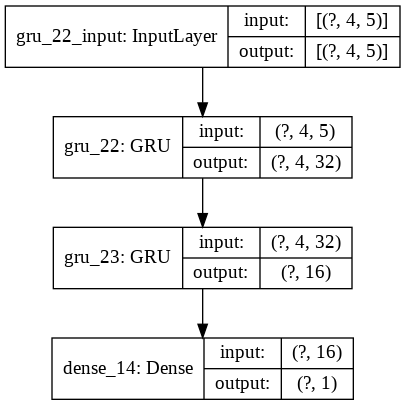

In [114]:
print(model_lat.summary())
tf.keras.utils.plot_model(model_lat, to_file='my_model.png', show_shapes=True, show_layer_names=True)

##Longtitude

In [0]:
model_long = tf.keras.models.Sequential()
model_long.add(tf.keras.layers.GRU(32, return_sequences=True,
                                        input_shape=x_train_long.shape[-2:]))
model_long.add(tf.keras.layers.GRU(16, activation='relu'))
model_long.add(tf.keras.layers.Dense(future_target))

model_long.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_24 (GRU)                 (None, 4, 32)             3744      
_________________________________________________________________
gru_25 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________
None


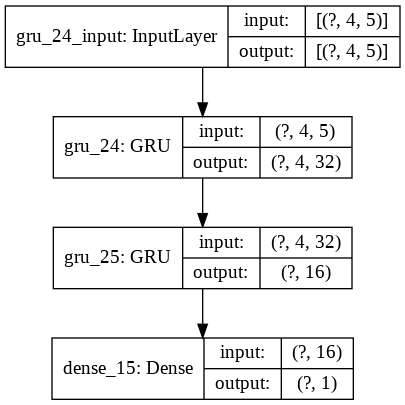

In [116]:
print(model_long.summary())
tf.keras.utils.plot_model(model_long, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Speed

In [0]:
model_wind = tf.keras.models.Sequential()
model_wind.add(tf.keras.layers.GRU(32, return_sequences=True,
                                        input_shape=x_train_wind.shape[-2:]))
model_wind.add(tf.keras.layers.GRU(16, activation='relu'))
model_wind.add(tf.keras.layers.Dense(future_target))

model_wind.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 4, 32)             3744      
_________________________________________________________________
gru_27 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________
None


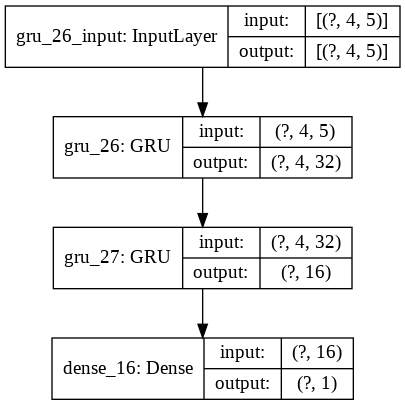

In [118]:
print(model_wind.summary())
tf.keras.utils.plot_model(model_wind, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Pressure

In [0]:
model_pres = tf.keras.models.Sequential()
model_pres.add(tf.keras.layers.GRU(32, return_sequences=True,
                                        input_shape=x_train_pres.shape[-2:]))
model_pres.add(tf.keras.layers.GRU(16, activation='relu'))
model_pres.add(tf.keras.layers.Dense(future_target))

model_pres.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 4, 32)             3744      
_________________________________________________________________
gru_29 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________
None


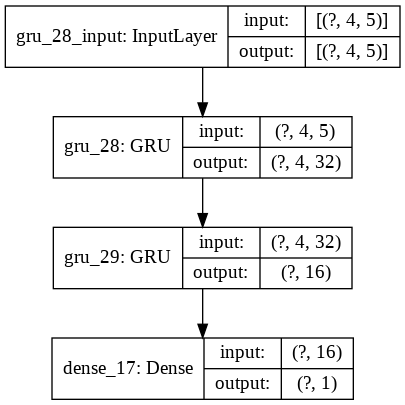

In [120]:
print(model_pres.summary())
tf.keras.utils.plot_model(model_pres, to_file='my_model.png', show_shapes=True, show_layer_names=True)

##Direction

In [0]:
model_dir = tf.keras.models.Sequential()
model_dir.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                       input_shape=x_train_dir.shape[-2:]))
model_dir.add(tf.keras.layers.LSTM(16, activation="relu"))
model_dir.add(tf.keras.layers.Dense(future_target))

model_dir.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


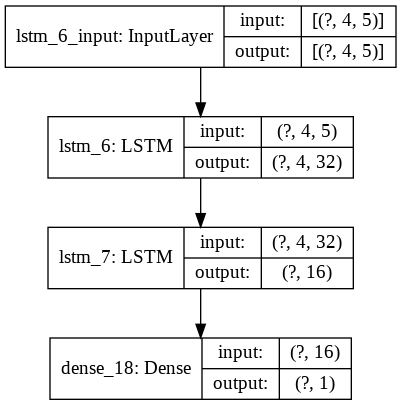

In [122]:
print(model_dir.summary())
tf.keras.utils.plot_model(model_dir, to_file='my_model.png', show_shapes=True, show_layer_names=True)

# Training & testing

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

## Parameters

In [0]:
EPOCH_STEPS = TRAIN_SPLIT
VAL_STEPS = len(hurricane_SID) - TRAIN_SPLIT
EPOCHS = 100
PATIENCE = 20

## Latitude

In [151]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks_lat = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_lat.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_lat.fit(train_data_lat,
                                   epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                   validation_data=val_data_lat,
                                   callbacks=callbacks_lat)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0270 - mae: 0.0270 - mse: 0.0063 - val_loss: 0.0150 - val_mae: 0.0150 - val_mse: 0.0047
Epoch 2/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0217 - mae: 0.0218 - mse: 0.0056 - val_loss: 0.0151 - val_mae: 0.0151 - val_mse: 0.0048
Epoch 3/100
403/403 [==============================] - 4s 9ms/step - loss: 0.0212 - mae: 0.0213 - mse: 0.0054 - val_loss: 0.0142 - val_mae: 0.0142 - val_mse: 0.0048
Epoch 4/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0213 - mae: 0.0213 - mse: 0.0055 - val_loss: 0.0155 - val_mae: 0.0155 - val_mse: 0.0049
Epoch 5/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0252 - mae: 0.0252 - mse: 0.0060 - val_loss: 0.0179 - val_mae: 0.0179 - val_mse: 0.0046
Epoch 6/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0238 - mae: 0.0239 - mse: 0.0060 - val_loss: 0.0144 - 

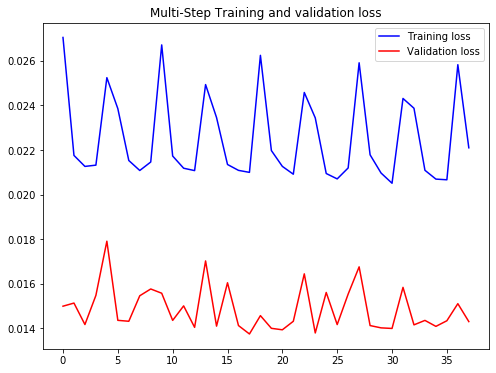

In [152]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

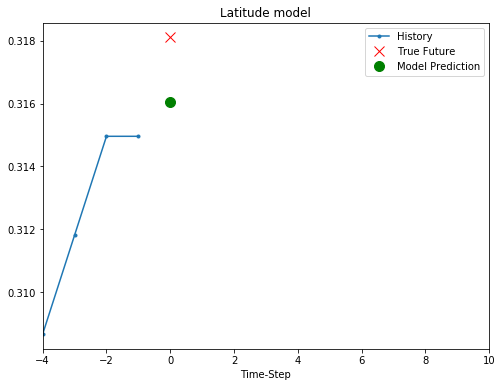

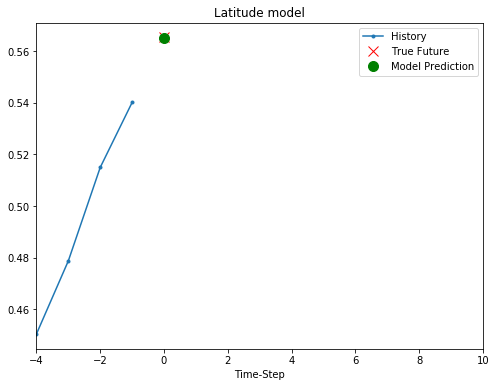

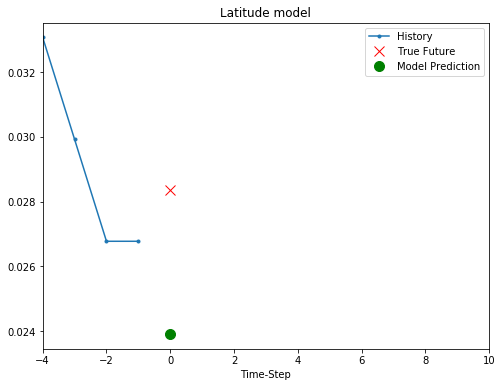

In [153]:
for x, y in val_data_lat.take(3):
  plot = show_plot([x[0][:,0].numpy(), y[0].numpy(),
                    model_lat.predict(x)[0]], 0, 'Latitude model')
  plot.show()

## Longtitude

In [154]:
# Set callback functions to early stop training and save the best model so far
callbacks_long = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_long.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_long.fit(train_data_long,
                                   epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                   validation_data=val_data_long,
                                   callbacks=callbacks_long)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0228 - mae: 0.0229 - mse: 0.0043 - val_loss: 0.0143 - val_mae: 0.0142 - val_mse: 0.0027
Epoch 2/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0193 - mae: 0.0194 - mse: 0.0036 - val_loss: 0.0116 - val_mae: 0.0116 - val_mse: 0.0027
Epoch 3/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0192 - mae: 0.0193 - mse: 0.0037 - val_loss: 0.0179 - val_mae: 0.0179 - val_mse: 0.0029
Epoch 4/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0195 - mae: 0.0195 - mse: 0.0037 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 0.0028
Epoch 5/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0213 - mae: 0.0214 - mse: 0.0040 - val_loss: 0.0131 - val_mae: 0.0130 - val_mse: 0.0026
Epoch 6/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0202 - mae: 0.0202 - mse: 0.0039 - val_loss: 0.0122 - 

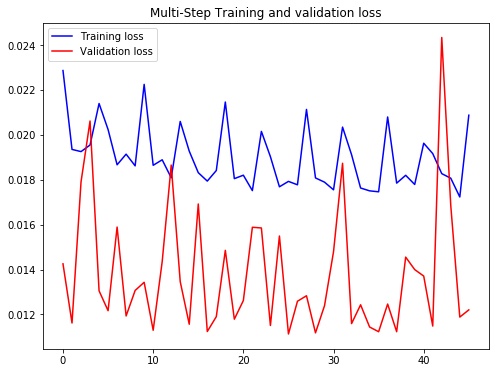

In [155]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

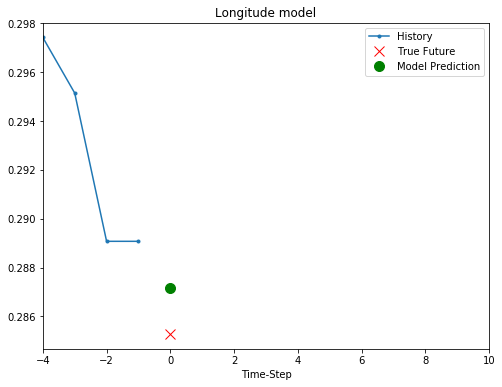

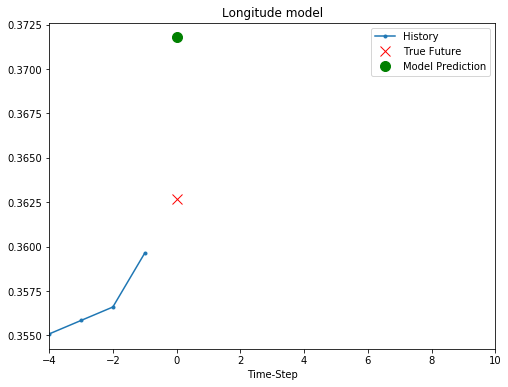

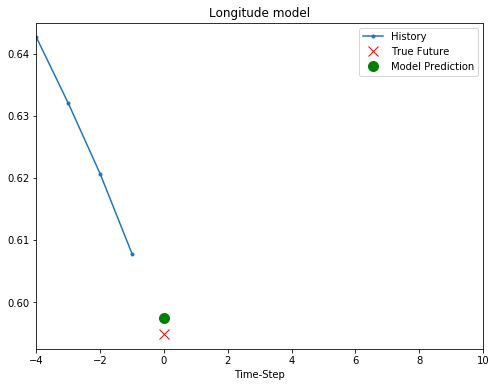

In [156]:
for x, y in val_data_long.take(3):
  plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                    model_long.predict(x)[0]], 0, 'Longitude model')
  plot.show()

## Wind Speed

In [157]:
# Set callback functions to early stop training and save the best model so far
callbacks_wind = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_wind.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_wind.fit(train_data_wind,
                                    epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_wind,
                                    callbacks=callbacks_wind)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0406 - mae: 0.0406 - mse: 0.0054 - val_loss: 0.0264 - val_mae: 0.0265 - val_mse: 0.0015
Epoch 2/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0324 - mae: 0.0324 - mse: 0.0035 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 0.0014
Epoch 3/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0312 - mae: 0.0312 - mse: 0.0034 - val_loss: 0.0242 - val_mae: 0.0242 - val_mse: 0.0014
Epoch 4/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0312 - mae: 0.0313 - mse: 0.0034 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 0.0014
Epoch 5/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0372 - mae: 0.0373 - mse: 0.0048 - val_loss: 0.0303 - val_mae: 0.0303 - val_mse: 0.0018
Epoch 6/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0355 - mae: 0.0355 - mse: 0.0043 - val_loss: 0.0245 - 

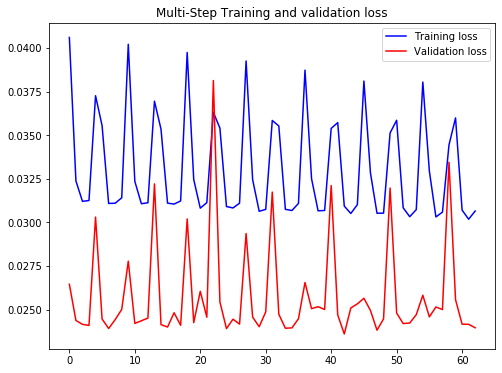

In [158]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

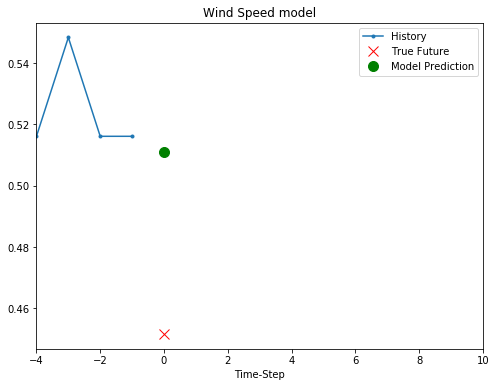

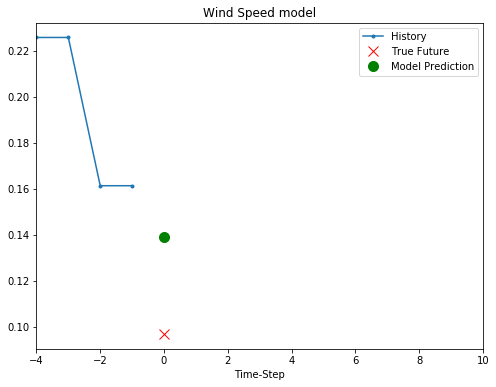

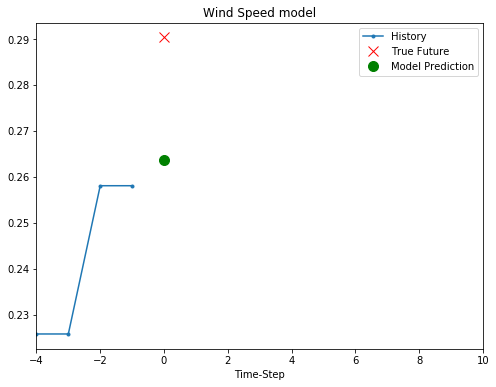

In [159]:
for x, y in val_data_wind.take(3):
  plot = show_plot([x[0][:,2].numpy(), y[0].numpy(),
                    model_wind.predict(x)[0]], 0, 'Wind Speed model')
  plot.show()

## Wind Pressure

In [160]:
# Set callback functions to early stop training and save the best model so far
callbacks_pres = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_pres.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_pres.fit(train_data_pres,
                                    epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_pres,
                                    callbacks=callbacks_pres)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0320 - mae: 0.0320 - mse: 0.0039 - val_loss: 0.0195 - val_mae: 0.0195 - val_mse: 0.0010
Epoch 2/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0247 - mae: 0.0247 - mse: 0.0025 - val_loss: 0.0159 - val_mae: 0.0159 - val_mse: 7.9707e-04
Epoch 3/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0024 - val_loss: 0.0156 - val_mae: 0.0156 - val_mse: 7.7900e-04
Epoch 4/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0239 - mae: 0.0240 - mse: 0.0024 - val_loss: 0.0176 - val_mae: 0.0176 - val_mse: 8.1631e-04
Epoch 5/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0289 - mae: 0.0290 - mse: 0.0035 - val_loss: 0.0197 - val_mae: 0.0197 - val_mse: 9.8839e-04
Epoch 6/100
403/403 [==============================] - 3s 8ms/step - loss: 0.0267 - mae: 0.0267 - mse: 0.0028 - val

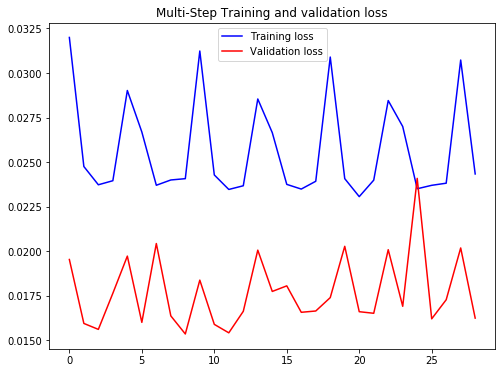

In [161]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

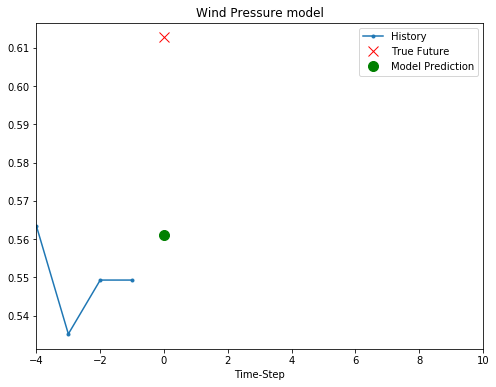

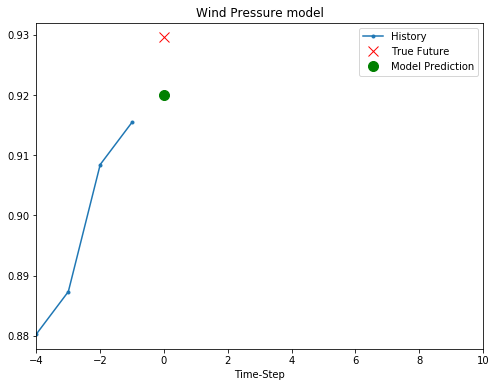

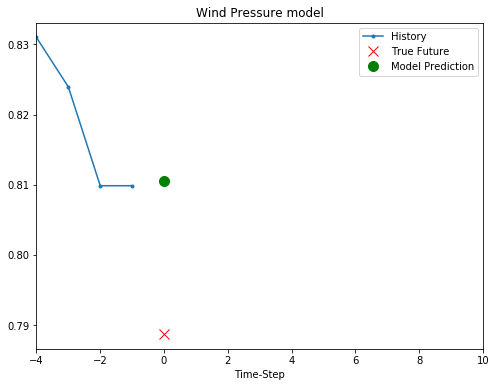

In [162]:
for x, y in val_data_pres.take(3):
  plot = show_plot([x[0][:,3].numpy(), y[0].numpy(),
                    model_pres.predict(x)[0]], 0, 'Wind Pressure model')
  plot.show()

##Direction

In [163]:
# Set callback functions to early stop training and save the best model so far
callbacks_dir = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_dir.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_dir.fit(train_data_dir,
                                   epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                   validation_data=val_data_dir,
                                   callbacks=callbacks_dir)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1177 - mae: 0.1179 - mse: 0.0710 - val_loss: 0.0850 - val_mae: 0.0850 - val_mse: 0.0442
Epoch 2/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1034 - mae: 0.1036 - mse: 0.0615 - val_loss: 0.0808 - val_mae: 0.0808 - val_mse: 0.0462
Epoch 3/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1024 - mae: 0.1026 - mse: 0.0608 - val_loss: 0.0807 - val_mae: 0.0807 - val_mse: 0.0467
Epoch 4/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1008 - mae: 0.1010 - mse: 0.0597 - val_loss: 0.0811 - val_mae: 0.0810 - val_mse: 0.0457
Epoch 5/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1140 - mae: 0.1143 - mse: 0.0688 - val_loss: 0.0822 - val_mae: 0.0822 - val_mse: 0.0452
Epoch 6/100
403/403 [==============================] - 3s 7ms/step - loss: 0.1080 - mae: 0.1081 - mse: 0.0639 - val_loss: 0.0874 - 

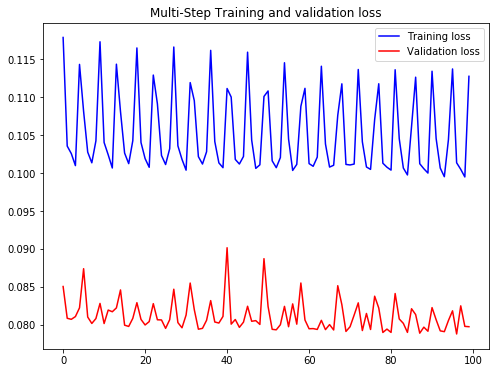

In [164]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# Testing Network: 24h Trajectory and Intensity Prediction
Test network and plot paths on a map for a given storm.

In [0]:
lat_min = data_min[0]
lat_max = data_max[0]
long_min = data_min[1]
long_max = data_max[1]


def tensor_to_array(tensor1):
    return tensor1.numpy()

def un_normalize_long_lat(lat, long):
  new_lat = (lat * (lat_max-lat_min)) + lat_min
  new_long = (long * (long_max-long_min)) + long_min
  return new_lat, new_long

def tuple_to_lists(list_tuples):
  list0 = []
  list1 = []
  for x,y in list_tuples:
    list0.append(x)
    list1.append(y)
  return list0, list1

In [0]:
best_model_lat = tf.keras.models.load_model('best_model_lat.h5')
best_model_long =  tf.keras.models.load_model('best_model_long.h5')
best_model_wind =  tf.keras.models.load_model('best_model_wind.h5')
best_model_pres =  tf.keras.models.load_model('best_model_pres.h5')
best_model_dir =  tf.keras.models.load_model('best_model_dir.h5')

def get_24hstorm_prediction(storm):
  history = []
  expected = []
  actual = []
  
  history_pres = []
  expected_pres = []
  actual_pres = []

  for i in range(0,4):
    history.append(un_normalize_long_lat(storm[i][0], storm[i][1]))
    history_pres.append(storm[i][3])

  input_x = np.array(storm[0:4])

  for i in range(4,8):

    x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])
    output_y = np.array(storm[i+1])
    y = output_y.reshape(1, output_y.shape[0], 1)

    predicted_lat = best_model_lat.predict(x)
    predicted_long = best_model_long.predict(x)
    predicted_wind = best_model_wind.predict(x)
    predicted_pres = best_model_pres.predict(x)
    predicted_dir = best_model_dir.predict(x)

    predicted = [float(predicted_lat), float(predicted_long), float(predicted_wind), float(predicted_pres), float(predicted_dir)]
    
    expected.append(un_normalize_long_lat(storm[i][0], storm[i][1]))
    actual.append(un_normalize_long_lat(predicted[0], predicted[1]))
    expected_pres.append(storm[i][3])
    actual_pres.append(predicted[3])

    new_input = []
    for j in range(i-3,i):
      new_input.append(storm[j])
    new_input.append(predicted)
    input_x = np.array(new_input)

  return history, actual, expected, history_pres, actual_pres, expected_pres

In [0]:
STEP = 1

def plot_hurricane_prediction_map(i):
  name = hurricane_SID[i]
  storm = retreiveDatasetByName(name, df, dataset)

  history, actual, expected, history_pres, actual_pres, expected_pres = get_24hstorm_prediction(storm)
  actual = [history[-1]] + actual
  expected = [history[-1]] + expected
  history_lat, history_long = tuple_to_lists(history)
  actual_lat, actual_long = tuple_to_lists(actual)
  expected_lat, expected_long = tuple_to_lists(expected)

  history_lat = np.array(history_lat)
  history_long = np.array(history_long)

  actual_lat = np.array(actual_lat)
  actual_long = np.array(actual_long)

  expected_lat = np.array(expected_lat)
  expected_long = np.array(expected_long)

  multi_step_plot(history_lat, expected_lat[1:], actual_lat[0:-1], name+" Latitude")
  multi_step_plot(history_long, expected_long[1:], actual_long[0:-1], name+" Longtitude")
  multi_step_plot(np.array(history_pres), np.array(expected_pres), np.array(actual_pres), name+" Wind Pressure")

  ave_lat = sum(p[0] for p in actual)/len(actual)
  ave_long = sum(p[1] for p in actual)/len(actual)

  # Load map centred on average coordinates
  my_map = folium.Map(location=[ave_lat, ave_long], zoom_start=8)

  plot_path_actual(actual,actual_pres, my_map)
  plot_path_predicted(expected, expected_pres, my_map)
  plot_path_history(history, history_pres, my_map)

  # Save map
  map_str = "./map-" + name + ".html"
  my_map.save(map_str)

  display(my_map)

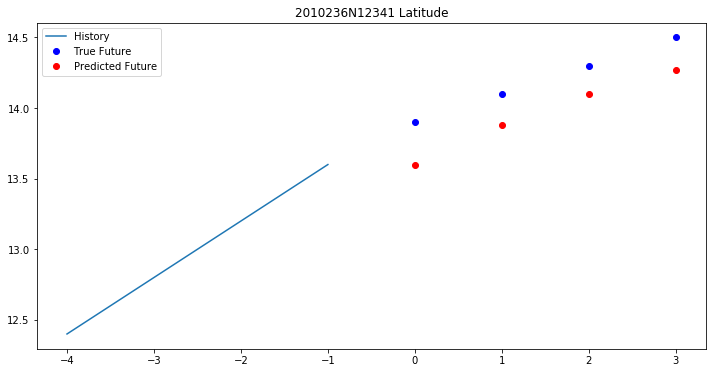

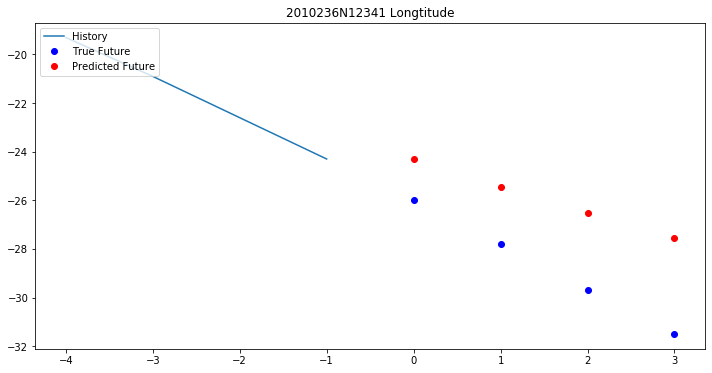

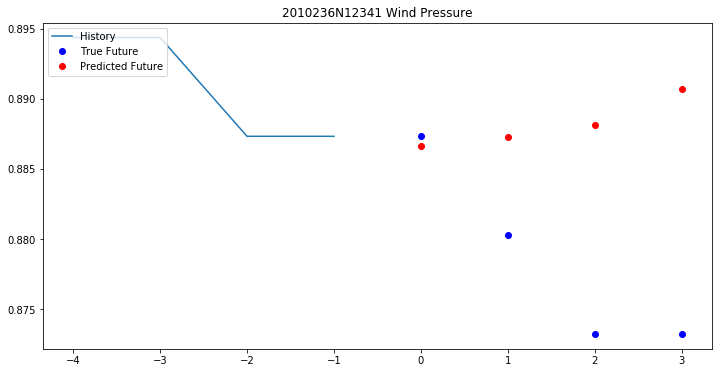

In [168]:
plot_hurricane_prediction_map(367)

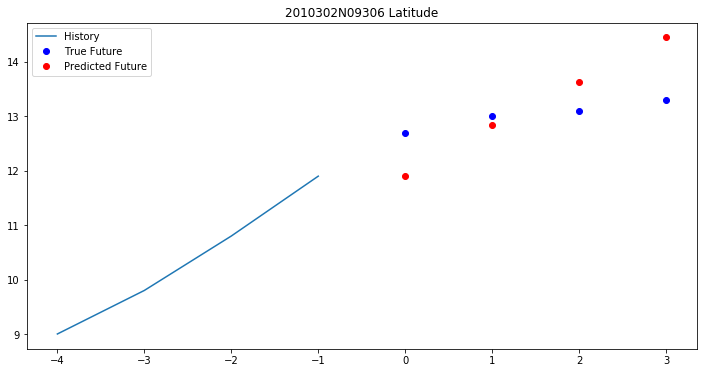

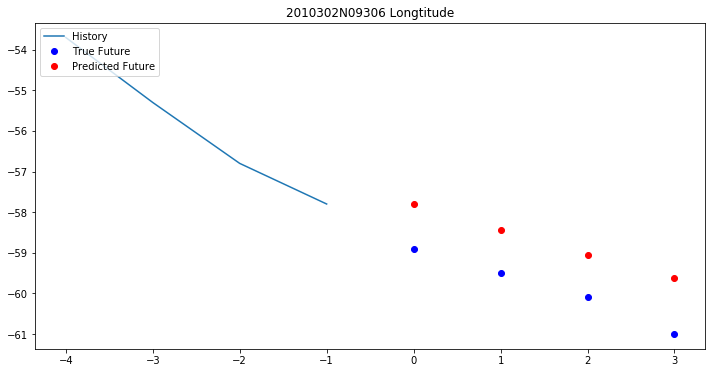

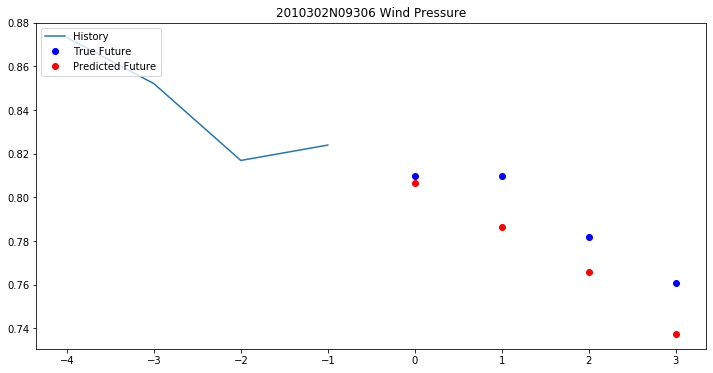

In [169]:
plot_hurricane_prediction_map(380)

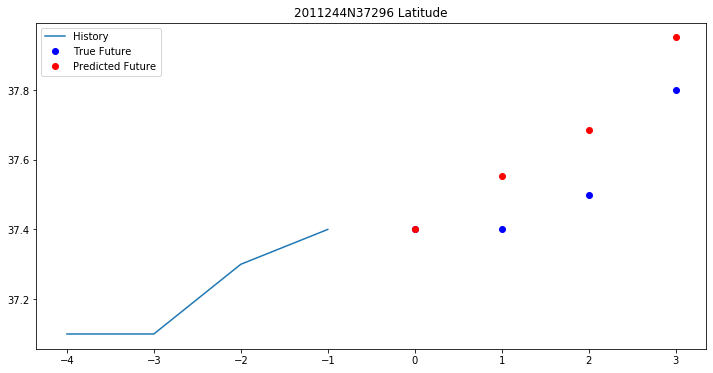

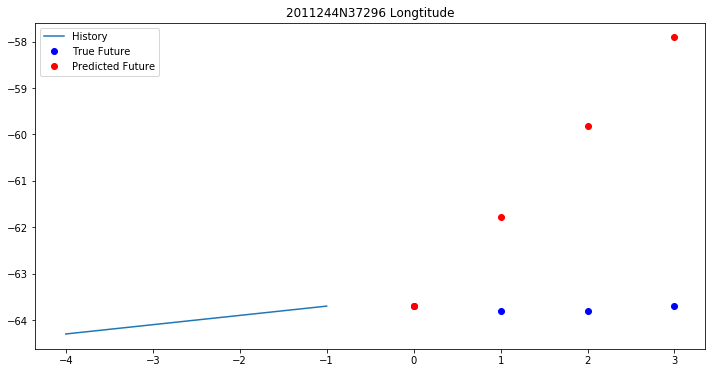

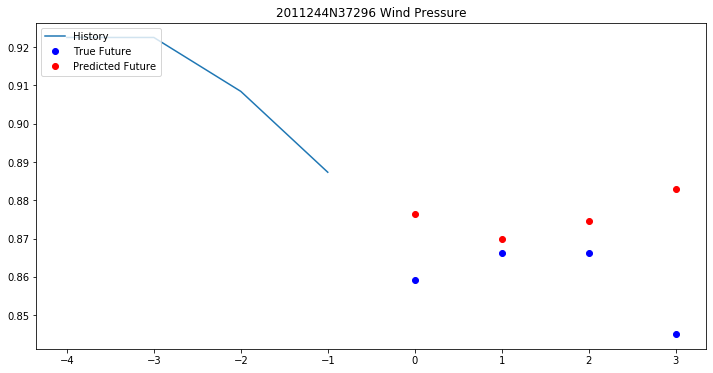

In [170]:
plot_hurricane_prediction_map(394)